In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
photo = plt.imread('data/flowers/photo.jpg', format='jpeg')
depth = plt.imread('data/flowers/depth.jpg', format='jpeg')

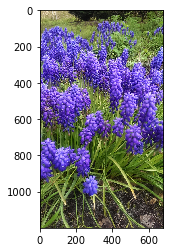

In [31]:
plt.imshow(photo)

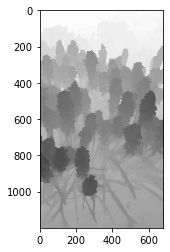

In [33]:
plt.imshow(depth)

bright is high, dark is low

In [176]:
# all units in mm

In [177]:
f_base = 13
f_target = 80

In [187]:
closest_point = 500 
furthest_point = 10000

In [269]:
distance = closest_point + (furthest_point-closest_point)*np.exp(depth/255)/np.exp(1)

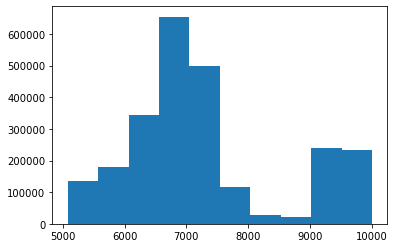

In [270]:
plt.hist(distance.flatten())
plt.show()

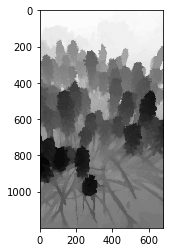

In [272]:
plt.imshow(distance[:,:,0], cmap='Greys_r')

In [273]:
class Optic:
    
    def __init__(self, focal_distance_in_mm):
        self.focal = focal_distance_in_mm
        
    def image_distance(self, depth_in_mm):
        assert depth_in_mm.min() > self.focal, \
        'check that depth_in_mm.min() = %s > self.focal = %s' % (depth_in_mm.min(), self.focal)
        return 1/(np.ones(depth_in_mm.shape)/self.focal - 1/depth_in_mm)

In [274]:
def get_magnification(f_base, f_target, depth):
    optic_base = Optic(f_base)
    optic_target = Optic(f_target)
    return optic_base.image_distance(depth)/optic_target.image_distance(depth)

In [275]:
magnification = get_magnification(f_base, f_target, distance)
magnification = magnification/magnification.min()

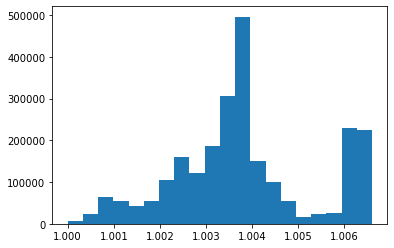

In [276]:
_, magbins, _ = plt.hist(magnification.flatten(), bins=20)

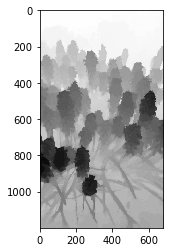

In [278]:
plt.imshow(magnification[:,:,0], cmap='Greys_r')

In [279]:
bindex = 10

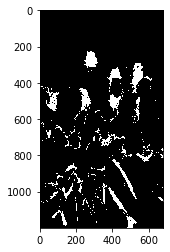

In [281]:
plt.imshow(np.logical_and(
    magnification >= magbins[bindex-1],
    magnification <= magbins[bindex]
)[:,:,0], cmap='Greys_r')

In [304]:
def get_image_segment(image, maglow, maghigh, mag):
    outimage = np.zeros(image.shape)
    outseg = np.logical_and(mag >= maglow, mag <= maghigh)
    outimage[outseg] = image[outseg]
    return outimage.astype(int)

In [305]:
photoseg = get_image_segment(photo, magbins[bindex-1], magbins[bindex], magnification)

In [306]:
photoseg.shape

(1200, 680, 3)

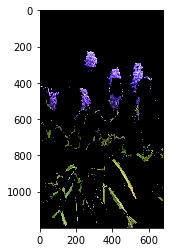

In [307]:
plt.imshow(photoseg, cmap='Greys_r')

In [198]:
# apply magnification to each point
# (x, y) -> (m*x, m*y) 
# where (0, 0) is at center of image

In [215]:
from skimage.transform import rescale

In [310]:
magbins[bindex]

1.0032995873822652

In [319]:
photoseg[0,0,:]

array([0, 0, 0])

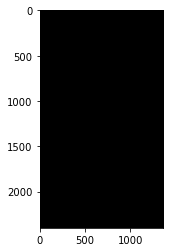

In [325]:
plt.imshow(rescale(photoseg, 2))

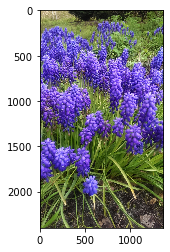

In [326]:
plt.imshow(rescale(photo, 2))

problem with scaling interpolator. splines eat up the pixels!